In [1]:
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

## 工作目录等基础设置

In [2]:
demo = False

if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = './data/cifar-10/'

In [3]:
if torch.cuda.is_available():
    print("CUDA is available!")
else:
    print("CUDA is not available.")

CUDA is available!


## 整理数据集

我们需要整理数据集来训练和测试模型。
首先，我们用以下函数读取CSV文件中的标签，它返回一个字典，该字典将文件名中不带扩展名的部分映射到其标签。


In [4]:
#@save
def read_csv_labels(fname):
    """读取fname来给标签字典返回一个文件名"""
    with open(fname, 'r') as f:
        # 跳过文件头行(列名)
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))

labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
print('# 训练样本 :', len(labels))
print('# 类别 :', len(set(labels.values())))

# 训练样本 : 50000
# 类别 : 10


将样本数据集的批量大小设置为128 </br>
将10％的训练样本作为调整超参数的验证集

In [5]:
batch_size = 128
valid_ratio = 0.1

## 图像增广

使用图像增广来解决过拟合的问题。</br>
裁剪图片到32*32适应模型输入。</br>
随机水平翻转图像。</br>
对彩色图像的三个RGB通道执行标准化。</br>

In [6]:
transform_train = torchvision.transforms.Compose([
    # 在高度和宽度上将图像放大到40像素的正方形
    torchvision.transforms.Resize(40),
    # 随机裁剪出一个高度和宽度均为40像素的正方形图像，
    # 生成一个面积为原始图像面积0.64～1倍的小正方形，
    # 然后将其缩放为高度和宽度均为32像素的正方形
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),
                                                   ratio=(1.0, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    # 标准化图像的每个通道
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

在测试期间，我们只对图像执行标准化，以消除评估结果中的随机性。


In [7]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

## 读取数据集

接下来，我们[**读取由原始图像组成的数据集**]，每个样本都包括一张图片和一个标签。


In [8]:
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

分别给训练集和验证集使用上述定义的**图像处理操作**

In [9]:
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

## 定义[**模型**]


使用了三个模型分别进行训练，下面是其中两个模型的展示：</br>
### **resnet18**

In [10]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7),
        padding = 3 if kernel_size == 7 else 1
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class Residual(nn.Module):
    def __init__(self, in_channels, out_channels, use_1x1conv=False, strides=1):
        super(Residual, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=strides)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.ca = ChannelAttention(out_channels)
        self.sa = SpatialAttention()
        self.relu = nn.ReLU(inplace=True)

    def forward(self, X):
        Y = self.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        Y = self.ca(Y) * Y
        Y = self.sa(Y) * Y
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return self.relu(Y)

def resnet_block(in_channels, out_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(in_channels, out_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(out_channels, out_channels))
    return nn.Sequential(*blk)

def resnet18(num_classes, in_channels=1):
    net = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU())
    net.add_module("resnet_block1", resnet_block(64, 64, 2, first_block=True))
    net.add_module("resnet_block2", resnet_block(64, 128, 2))
    net.add_module("resnet_block3", resnet_block(128, 256, 2))
    net.add_module("resnet_block4", resnet_block(256, 512, 2))
    net.add_module("global_avg_pool", nn.AdaptiveAvgPool2d((1,1)))
    net.add_module("fc", nn.Sequential(nn.Flatten(), nn.Linear(512, num_classes)))
    return net

### resnet56

In [11]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class myResNet56(nn.Module):

    def __init__(self, num_classes=10):
        super(myResNet56, self).__init__()
        self.inplanes = 16
        self.conv1 = conv3x3(3, 16)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(BasicBlock, 16, 9)
        self.layer2 = self._make_layer(BasicBlock, 32, 9, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 64, 9, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64 * BasicBlock.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

## 定义[**训练函数**]

我们将根据模型在验证集上的表现来选择模型并调整超参数。</br>
下面我们定义了模型训练函数`train`。</br>
加入新的bool参数`savemodel`，若置为True则会在训练时每五个epoch记录一次模型，便于回溯模型性能。</br>
优化器由SGD改为RMSprop。</br>
限制ylim[0,1]增强输出结果可阅读性。

In [12]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay, savemodel=False):
    #优化器更改
    #trainer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    trainer = torch.optim.RMSprop(net.parameters(), lr=lr, weight_decay=wd)
    
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', 
                            xlim=[1, num_epochs],
                            ylim=[0,1],
                            legend=legend)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    
    
    save_interval = 5  # Save model every 20 epochs
    save_counter = 0
    
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels,
                                          loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
        
        if (savemodel and (epoch + 1) % save_interval == 0):
            save_counter += 1
            save_path = './model/' + 'resnet56_' + str(save_counter*5) + 'epoch.pth'
            print(save_path)
            torch.save(net, save_path)
            
            
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

## [**训练和验证模型**]
`lr_period`和`lr_decay`分别设置为4和0.9时，优化算法的学习速率将在每4个周期乘以0.9。</br>
为快速评估模型效果以及超参数的选择，只训练20个周期。


### resnet56模型结构

In [13]:
model_resnet56 = myResNet56()
for n in model_resnet56.modules():
    print(n)

myResNet56(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

### resnet18模型结构

In [14]:
model_resnet18 = resnet18(10,3)
for n in model_resnet18.modules():
    print(n)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (resnet_block1): Sequential(
    (0): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (ca): ChannelAttention(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (max_pool): AdaptiveMaxPool2d(output_size=1)
        (fc1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (relu1): ReLU()
        (fc2): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (sigmoid): Sigmoid()
      )
      (sa): SpatialAttention(
        (conv1): Conv2d(2, 1, kernel_s

## 模型效果测试

### resnet18测试
无需保存模型

train loss 0.179, train acc 0.939, valid acc 0.826
1295.4 examples/sec on [device(type='cuda', index=0)]


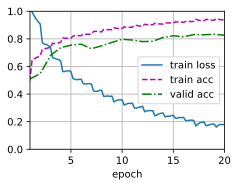

In [15]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 1e-4, 5e-4
lr_period, lr_decay, net = 4, 0.9, model_resnet18
loss = nn.CrossEntropyLoss(reduction="none")
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay,False)

### resnet56测试
无需保存模型

train loss 0.580, train acc 0.799, valid acc 0.728
2647.7 examples/sec on [device(type='cuda', index=0)]


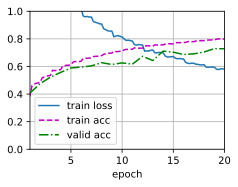

In [16]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 2e-4, 5e-4
lr_period, lr_decay, net = 4, 0.9, model_resnet56
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay,False)

## 完整训练
使用**resnet56**演示完整训练</br>
设置50个epoch，需要保存模型。

./model/resnet56_50epoch.pth
train loss 0.189, train acc 0.935
2596.4 examples/sec on [device(type='cuda', index=0)]


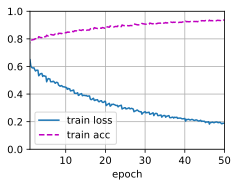

In [17]:
preds = []
num_epochs = 50
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay, True)

## 在 Kaggle 上[**对测试集进行分类并提交结果**]

在获得具有超参数的满意的模型后，我们使用所有标记的数据（包括验证集）来重新训练模型并对测试集进行分类。


In [19]:
preds =  []

for X, _ in test_iter:
    y_hat = net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key=lambda x: str(x))
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x])
df.to_csv('submission_myresnet56.csv', index=False)